In [1]:
#https://www.kaggle.com/carrie1/ecommerce-data

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes import GammaGammaFitter

In [3]:
data=pd.read_csv("data.csv",encoding="ISO-8859-1",parse_dates=["InvoiceDate"])
data=data.drop_duplicates().reset_index(drop=True)
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
536636,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
536637,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
536638,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
536639,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [4]:
for _,row in data.iterrows():
    #for each refunded row, search for corresponding purchased row having the same quantity 
    if row["Quantity"]<0:
        purchase_row=data[(data["StockCode"]==row["StockCode"])&(data["Quantity"]==(row["Quantity"]*-1))&
                          (data["InvoiceDate"]<row["InvoiceDate"])&(data["CustomerID"]==row["CustomerID"])]
        #remove last purchased row having the same quantity
        if (purchase_row.shape[0]>0):
            index=purchase_row.iloc[[-1]].index[0]
            data=data.drop([index])
        #search for corresponding purchased row having a larger quantity
        else:
            purchase_row=data[(data["StockCode"]==row["StockCode"])&(data["Quantity"]>(row["Quantity"]*-1))&
                              (data["InvoiceDate"]<row["InvoiceDate"])&(data["CustomerID"]==row["CustomerID"])]
            #replace quantity of last purchased row with original quantity plus refunded quantity
            if (purchase_row.shape[0]>0):
                index=purchase_row.iloc[[-1]].index[0]
                data.loc[index,"Quantity"]+=row["Quantity"]
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
536636,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
536637,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
536638,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
536639,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [5]:
data=data[data["Quantity"]>0]
data=data.dropna(subset=["CustomerID"])
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
536636,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
536637,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
536638,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
536639,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [6]:
data["Price"]=data["Quantity"]*data["UnitPrice"]
data["Date"]=data["InvoiceDate"].dt.date
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Price,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01
...,...,...,...,...,...,...,...,...,...,...
536636,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,2011-12-09
536637,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2011-12-09
536638,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-09
536639,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-09


In [7]:
data=data[["CustomerID","Date","Price"]].reset_index(drop=True)
data

,CustomerID,Date,Price
0,17850.0,2010-12-01,15.30
1,17850.0,2010-12-01,20.34
2,17850.0,2010-12-01,22.00
3,17850.0,2010-12-01,20.34
4,17850.0,2010-12-01,20.34
...,...,...,...
389808,12680.0,2011-12-09,10.20
389809,12680.0,2011-12-09,12.60
389810,12680.0,2011-12-09,16.60
389811,12680.0,2011-12-09,16.60


In [8]:
data.isnull().sum()

CustomerID    0
Date          0
Price         0
dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389813 entries, 0 to 389812
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   CustomerID  389813 non-null  float64
 1   Date        389813 non-null  object 
 2   Price       389813 non-null  float64
dtypes: float64(2), object(1)
memory usage: 8.9+ MB


In [10]:
max_date=data["Date"].max()
max_date

datetime.date(2011, 12, 9)

In [11]:
#transform transactional data (one row per purchase) into summary data (a frequency, recency and age dataset)
df=summary_data_from_transaction_data(data,"CustomerID","Date",monetary_value_col="Price",observation_period_end=max_date)
df

,frequency,recency,T,monetary_value
CustomerID,,,,
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000
12352.0,5.0,260.0,296.0,417.842000
...,...,...,...,...
18280.0,0.0,0.0,277.0,0.000000
18281.0,0.0,0.0,180.0,0.000000
18282.0,1.0,119.0,126.0,77.840000


In [12]:
df.describe()

,frequency,recency,T,monetary_value
count,4328.000000,4328.000000,4328.000000,4328.000000
mean,2.853512,130.690850,222.893253,264.243396
std,5.925060,132.132412,117.825958,552.947089
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,112.750000,0.000000
50%,1.000000,93.000000,248.000000,173.925000
75%,3.000000,252.000000,326.000000,354.587680
max,129.000000,373.000000,373.000000,21535.900000


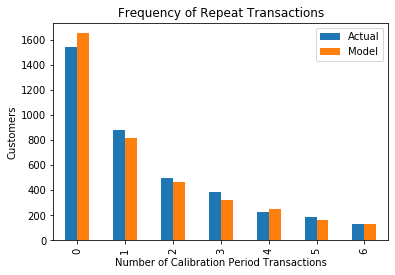

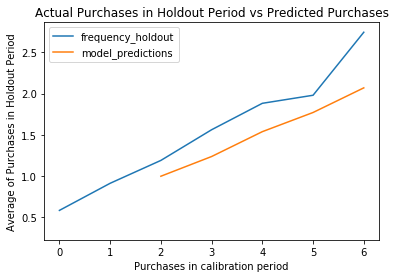

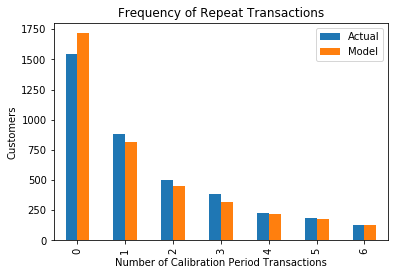

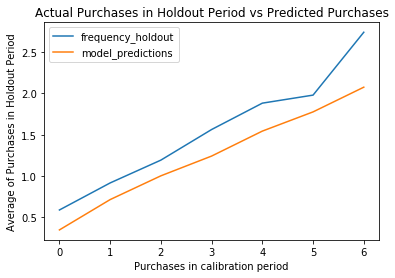

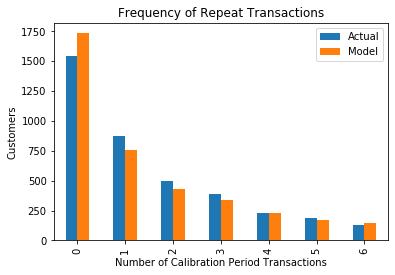

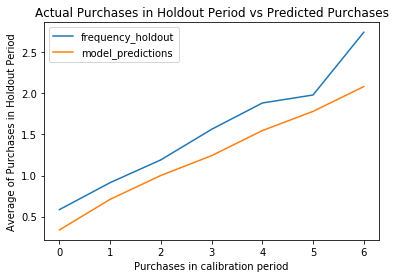

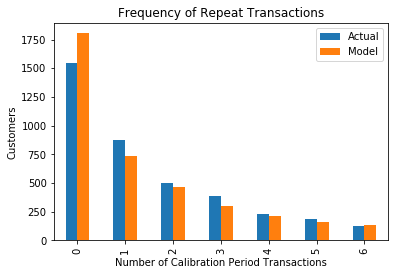

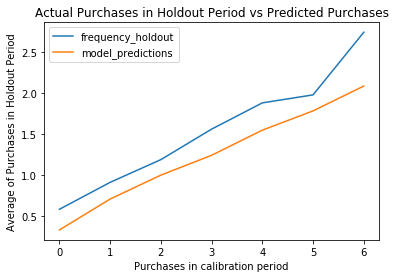

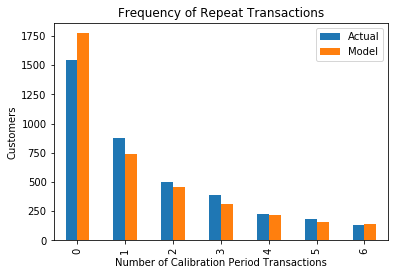

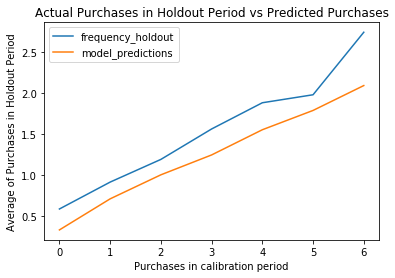

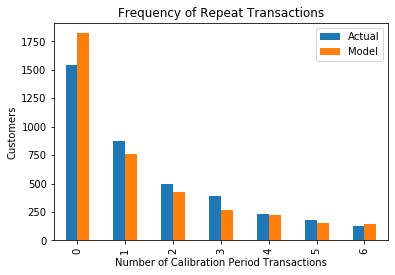

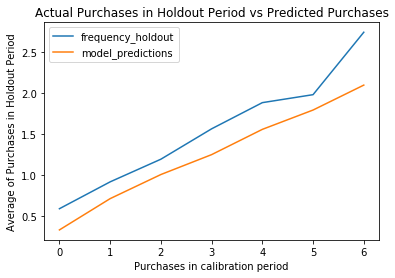

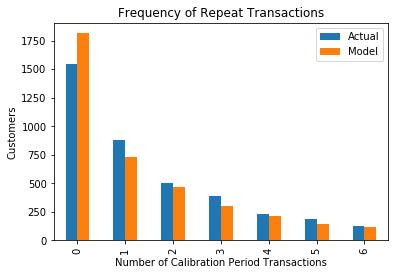

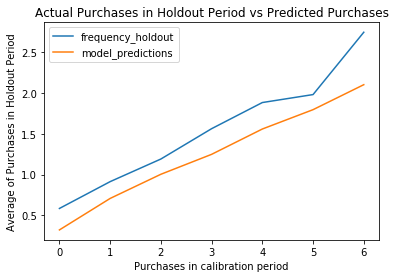

In [13]:
#search for BetaGeoFitter best penalizer coefficient
for value in np.linspace(0.04,0.1,7):
    bgf=BetaGeoFitter(penalizer_coef=value)
    bgf.fit(df["frequency"],df["recency"],df["T"])
    plot_period_transactions(bgf)
    summary_cal_holdout=calibration_and_holdout_data(data,"CustomerID","Date",calibration_period_end="2011-9-9",observation_period_end=max_date)
    bgf.fit(summary_cal_holdout["frequency_cal"],summary_cal_holdout["recency_cal"],summary_cal_holdout["T_cal"])
    plot_calibration_purchases_vs_holdout_purchases(bgf,summary_cal_holdout)

In [14]:
#frequency/recency analysis using the BG/NBD model
bgf=BetaGeoFitter(penalizer_coef=0.05)
bgf.fit(df["frequency"],df["recency"],df["T"])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4328 subjects, a: 0.00, alpha: 55.99, b: 0.00, r: 0.67>


In [15]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,6.693746e-01,0.018069,0.633959,0.704790
alpha,5.599134e+01,1.909782,52.248170,59.734514
a,5.820654e-21,NaN,NaN,NaN
b,1.333877e-11,NaN,NaN,NaN


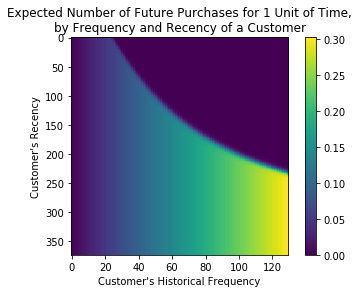

In [16]:
#visualise the frequency/recency matrix
#computes the expected number of transactions a artificial customer is to make in the next time period, given his or her recency (age at last purchase) and frequency (the number of repeat transactions he or she has made)
plot_frequency_recency_matrix(bgf)

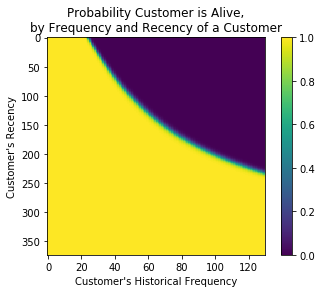

In [17]:
#visualise the frequency/recency matrix
#probability of still being alive
plot_probability_alive_matrix(bgf)

In [18]:
#ranking customers from best to worst
#predict a customer’s expected purchases in the next period using their history
#predicted_purchases is the predicted number of purchases
t=30
df["predicted_purchases"]=bgf.conditional_expected_number_of_purchases_up_to_time(t,df["frequency"],df["recency"],df["T"])
df.sort_values(by="predicted_purchases").tail(20)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
17315.0,34.0,356.0,357.0,180.851765,2.518409
13263.0,32.0,324.0,325.0,227.977188,2.572450
16029.0,38.0,335.0,373.0,1705.541053,2.704207
13408.0,40.0,372.0,373.0,672.078750,2.844070
17811.0,37.0,329.0,333.0,200.590811,2.905158
15189.0,37.0,331.0,332.0,417.108108,2.912646
15039.0,41.0,359.0,368.0,464.711707,2.948365
14156.0,42.0,362.0,371.0,2714.803810,2.997909
14096.0,16.0,97.0,101.0,4071.434375,3.185406


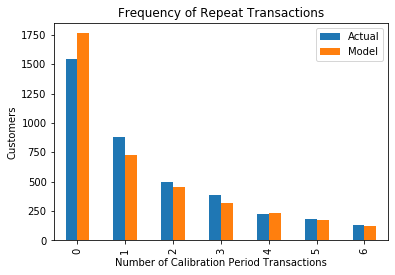

In [19]:
#assessing model fit
#method 1: compare data versus artificial data simulated with fitted model’s parameters
plot_period_transactions(bgf)

In [20]:
# assessing model fit
#method 2: partition the dataset into a calibration period dataset and a holdout dataset to test how the model performs on data not yet seen 
summary_cal_holdout=calibration_and_holdout_data(data,"CustomerID","Date",calibration_period_end="2011-9-9",observation_period_end=max_date)
print(summary_cal_holdout.head())

            frequency_cal  recency_cal  T_cal  frequency_holdout  \
CustomerID                                                         
12347.0               4.0        238.0  276.0                2.0   
12348.0               2.0        110.0  267.0                1.0   
12350.0               0.0          0.0  219.0                0.0   
12352.0               2.0         34.0  205.0                3.0   
12353.0               0.0          0.0  113.0                0.0   

            duration_holdout  
CustomerID                    
12347.0                   91  
12348.0                   91  
12350.0                   91  
12352.0                   91  
12353.0                   91  


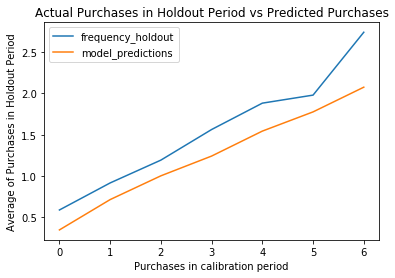

In [21]:
#perform fit on the _cal columns and test on the _holdout columns
bgf.fit(summary_cal_holdout["frequency_cal"],summary_cal_holdout["recency_cal"],summary_cal_holdout["T_cal"])
plot_calibration_purchases_vs_holdout_purchases(bgf,summary_cal_holdout)

In [22]:
#estimate customer lifetime value using the Gamma-Gamma model
returning_customers_summary=df[df["frequency"]>0]
print(returning_customers_summary.head())

            frequency  recency      T  monetary_value  predicted_purchases
CustomerID                                                                
12347.0           6.0    365.0  367.0      599.701667             0.473015
12348.0           3.0    283.0  358.0      301.480000             0.265902
12352.0           5.0    260.0  296.0      417.842000             0.483197
12356.0           2.0    303.0  325.0      269.905000             0.210192
12358.0           1.0    149.0  150.0      683.200000             0.243123


In [23]:
#the Gamma-Gamma model assumes that there is no relationship between the monetary value and the purchase frequency
#need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model
returning_customers_summary[["monetary_value","frequency"]].corr()

,monetary_value,frequency
monetary_value,1.000000,0.121814
frequency,0.121814,1.000000


In [24]:
#train the Gamma-Gamma model and predict the conditional, expected average lifetime value of the customers
ggf=GammaGammaFitter(penalizer_coef=0)
ggf.fit(returning_customers_summary["frequency"],returning_customers_summary["monetary_value"])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2784 subjects, p: 2.11, q: 3.52, v: 486.66>


In [25]:
#estimate the average transaction value
print(ggf.conditional_expected_average_profit(df["frequency"],df["monetary_value"]).head(10))

CustomerID
12347.0    567.635435
12348.0    331.506748
12349.0    406.806620
12350.0    406.806620
12352.0    415.711453
12353.0    406.806620
12354.0    406.806620
12355.0    406.806620
12356.0    321.143707
12357.0    406.806620
dtype: float64


In [26]:
print("Expected conditional average profit: %s, Average profit: %s"% 
      (ggf.conditional_expected_average_profit(df["frequency"],df["monetary_value"]).mean(),
       df[df["frequency"]>0]["monetary_value"].mean()))

Expected conditional average profit: 414.43219553790414, Average profit: 410.79217533758333


In [1]:
import numpy as np
import pandas as pd
import datetime as dt

from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter

In [2]:
def clean_data(data):
    
    data=pd.read_csv(data,encoding="ISO-8859-1",parse_dates=["InvoiceDate"])
    data=data.drop_duplicates().reset_index(drop=True)
    
    for _,row in data.iterrows():
        if row["Quantity"]<0:
            purchase_row=data[(data["StockCode"]==row["StockCode"])&(data["Quantity"]==(row["Quantity"]*-1))&
                              (data["InvoiceDate"]<row["InvoiceDate"])&(data["CustomerID"]==row["CustomerID"])]
            if (purchase_row.shape[0]>0):
                index=purchase_row.iloc[[-1]].index[0]
                data=data.drop([index])
            else:
                purchase_row=data[(data["StockCode"]==row["StockCode"])&(data["Quantity"]>(row["Quantity"]*-1))&
                                  (data["InvoiceDate"]<row["InvoiceDate"])&(data["CustomerID"]==row["CustomerID"])]
                if (purchase_row.shape[0]>0):
                    index=purchase_row.iloc[[-1]].index[0]
                    data.loc[index,"Quantity"]+=row["Quantity"]
    
    data=data[data["Quantity"]>0]
    data=data.dropna(subset=["CustomerID"])

    data["Price"]=data["Quantity"]*data["UnitPrice"]
    data["Date"]=data["InvoiceDate"].dt.date
    
    return data

In [3]:
def clv(data,period,customerid):
    
    data=data[["CustomerID","Date","Price"]].reset_index(drop=True)
    max_date=data["Date"].max()
    df=summary_data_from_transaction_data(data,"CustomerID","Date",monetary_value_col="Price",observation_period_end=max_date)
   
    bgf=BetaGeoFitter(penalizer_coef=0.05)
    bgf.fit(df["frequency"],df["recency"],df["T"])
    df["predicted_purchases"]=bgf.conditional_expected_number_of_purchases_up_to_time(period,df["frequency"],df["recency"],df["T"])
    df["probability"]=bgf.conditional_probability_alive(df["frequency"],df["recency"],df["T"])
    
    num_purchases=df.loc[customerid]["predicted_purchases"]
    alive=df.loc[customerid]["probability"]
    
    returning_customers_summary=df[df["frequency"]>0]
    ggf=GammaGammaFitter(penalizer_coef=0)
    ggf.fit(returning_customers_summary["frequency"],returning_customers_summary["monetary_value"])
    df["expected_monetary_value"]=ggf.conditional_expected_average_profit(df["frequency"],df["monetary_value"])
    
    exp_val=df.loc[customerid]["expected_monetary_value"]
    exp_avg_val=df["expected_monetary_value"].mean()
    avg_val=returning_customers_summary["monetary_value"].mean()
    
    print("Average transaction value: ${}".format(round(avg_val,2)))
    print("Expected average transaction value: ${}".format(round(exp_avg_val,2)))
    print("\n")
    print("Customerid: {}".format(customerid))
    print("Expected number of purchases in {} days: {}".format(period,round(num_purchases)))
    print("Expected transaction value: ${}".format(round(exp_val,2)))
    print("Probability customer is alive: {}".format(round(alive,2)))

    return df

In [ ]:
data=clean_data("data.csv")

In [ ]:
csv=clv(data,30,14911.0)